# 1 Author

**Student Name**:  Shobhit Rawat

**Student ID**:    230262571



# 2 Problem formulation

***I want to solve a machine learning problem that classifies images of dishes to figure out if they have rice or chips. It's an image classification task where the algorithm learns patterns and features in images to make predictions. What I find intriguing is that it's about recognizing food, a tough subset of image classification. I need to teach the model to understand subtle visual cues like texture, color, and arrangement in distinguishing between rice and chips.***

# 3 Machine Learning pipeline



In [2]:
!pip install mlend --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00


**Importing necessary libraries**

In [103]:
# Google Colab and Drive
from google.colab import drive

# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from skimage import exposure, color, feature, io, measure
from skimage.color import rgb2hsv, rgb2gray
from skimage.feature import greycomatrix, ORB, graycoprops, greycoprops
from skimage.measure import shannon_entropy
from PIL import Image
import cv2
from skimage.feature import greycomatrix
from skimage.feature import local_binary_pattern
import numpy as np
from skimage import exposure
from skimage import color, morphology



# Machine Learning
import mlend
from mlend import download_yummy, yummy_load
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, matthews_corrcoef, roc_curve, auc, accuracy_score
from sklearn.preprocessing import LabelEncoder
from skimage.feature import greycomatrix,graycomatrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import xgboost as xgb
from scipy.stats import iqr


# Utilities
import os, sys, re, pickle, glob, urllib.request, zipfile
from scipy.stats import iqr
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading the dataset and the image paths**

In [5]:
baseDir = download_yummy(save_to = '/content/drive/MyDrive/Data/MLEnd_Full')
baseDir
os.listdir(baseDir)

MLENDYD_df = pd.read_csv('/content/drive/MyDrive/Data/MLEnd_Full/yummy/MLEndYD_image_attributes_benchmark.csv')

sample_path = '/content/drive/MyDrive/Data/MLEnd_Full/yummy/MLEndYD_images/*.jpg'
files = glob.glob(sample_path)



100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|3250\3250|003250.jpg
Done!


# 4 Transformation stage
***The images undergo a two-step resizing process: first, they are adjusted to achieve a square shape, and subsequently, they are resized to a final dimension of 200x200 pixels. In case an image is grayscale, it undergoes conversion to RGB by replicating the channels.***

***The resultant processed images are saved in a NumPy array, and the function returns this array.***

***Following this, the code employs this function to process both the training and test images. The processed images are then stored in arrays named X_train and X_test, and their respective shapes are printed to the console.***

In [59]:
def resize_images(image_paths, target_size=(200, 200)):
    images = []

    for k, file in enumerate(tqdm(image_paths, desc="Processing images", unit="image")):
        I = Image.open(file)

        # Resize images
        I = I.resize((max(I.size), max(I.size)), Image.LANCZOS)
        I = I.resize(target_size, Image.LANCZOS)

        I_array = np.array(I)

        # If the image is grayscale, convert it to RGB
        if len(I_array.shape) == 2:
            I_array = np.stack((I_array,) * 3, axis=-1)

        images.append(I_array)

    return np.array(images)

X_train = resize_images(X_train_paths)

X_test = resize_images(X_test_paths)


Processing images: 100%|██████████| 299/299 [01:06<00:00,  4.49image/s]



***To decrease the dimensionality of the predictor space, we aim to transfer our samples from a 120,000-dimensional space to a space with fewer dimensions. In the following code cell, several functions—namely, get_yellow_component, GMLC_features,,edge_features,sift_features and skeletonization_features,
—are defined. These functions extract image features crucial for defining a new predictor space.***

In [60]:


def get_yellow_component(I,t1=27, t2=33):
  Ihsv = (rgb2hsv(I)*255).astype('uint8')
  mask = (Ihsv[:,:,0]<t2)*(Ihsv[:,:,0]>t1)
  Ypx = mask.sum()
  return Ypx


def edge_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    edge_mean = np.mean(edges)
    edge_variance = np.var(edges)

    return edge_mean


def GMLC_features(I):
  Ig = (rgb2gray(I)*255).astype('uint8')
  glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256,symmetric=True, normed=True)
  f1 = graycoprops(glcm, 'dissimilarity')[0, 0]
  f2 = graycoprops(glcm, 'correlation')[0, 0]
  f3 = greycoprops(glcm, 'contrast')[0, 0]
  f4 = greycoprops(glcm, 'energy')[0, 0]
  return f1,f2,f3,f4

def sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    _, des = sift.detectAndCompute(gray, None)
    return np.mean(des, axis=0) if des is not None else np.zeros(128)


def skeletonization_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary_image = gray_image < 0.5
    skeletonized_image = morphology.skeletonize(binary_image)
    skeleton_features = {
        'total_skeleton_pixels': np.sum(skeletonized_image),
        'mean_skeleton_width': np.mean(skeletonized_image[skeletonized_image > 0]),
    }

    return skeleton_features


def convert_to_uint8(image_path):
    return (image_path * 255).astype('uint8')


def extract_features(I):
    f1 = get_yellow_component(I)

    f2 = edge_features(I)
    f3, f4, f5, f6 = GMLC_features(I)
    f7 = np.mean(sift_features(I))
    f8 = skeletonization_features(I)['total_skeleton_pixels']


    return f1,f2,f3,f4,f5,f6, f7,f8

def process_image_list(image_list):
    feature_matrix = []

    for k, I in enumerate(image_list):
        features = extract_features(I)
        feature_matrix.append(features)

    return np.array(feature_matrix)

X_train_f = process_image_list(X_train)
X_test_f = process_image_list(X_test)


/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be remo


***Implemented a normalization stage to ensure that the attributes in the new prediction space exhibit a comparable range of values, alongside the reduction in dimensionality of the prediction space.***







In [61]:
import numpy as np

def min_max_normalize(data):
    transposed_array = data.T
    normalized_array = []

    for column in transposed_array:
        min_val = min(column)
        max_val = max(column)
        normalized_column = [(x - min_val) / (max_val - min_val) for x in column]
        normalized_array.append(normalized_column)

    normalized_feature_list = np.array(normalized_array).T.tolist()
    return np.array(normalized_feature_list)

X_train_fn = min_max_normalize(X_train_f)
X_test_fn = min_max_normalize(X_test_f)


***Showing first five rows of normalized train data***

In [62]:
X_train_fn[0:5]

array([[0.05652483, 0.54700228, 0.43934015, 0.34972508, 0.26292837,
        0.02797097, 0.55634201, 0.14545455],
       [0.34705661, 0.32966764, 0.42633736, 0.78888886, 0.36053361,
        0.03397608, 0.4401736 , 0.11818182],
       [0.09652316, 0.33561421, 0.42051617, 0.80182052, 0.44000173,
        0.0399609 , 0.63411426, 0.20909091],
       [0.09907535, 0.79529163, 0.67689137, 0.45056594, 0.50182694,
        0.00721173, 0.85100558, 0.11818182],
       [0.00150621, 0.2082926 , 0.37633855, 0.68611402, 0.32888786,
        0.05791634, 0.23208034, 0.14242424]])

***Showing first five rows of normalized test data***

In [63]:
X_train_f[0:5]

array([[1.35600000e+03, 5.38623750e+01, 2.35111795e+01, 5.28601795e-01,
        1.22706697e+03, 1.31609667e-02, 2.65197144e+01, 4.80000000e+01],
       [8.30000000e+03, 3.68538750e+01, 2.30217692e+01, 8.07666601e-01,
        1.59047541e+03, 1.45851126e-02, 2.54407158e+01, 3.90000000e+01],
       [2.31200000e+03, 3.73192500e+01, 2.28026667e+01, 8.15883971e-01,
        1.88635487e+03, 1.60044475e-02, 2.72420807e+01, 6.90000000e+01],
       [2.37300000e+03, 7.32933750e+01, 3.24523333e+01, 5.92680700e-01,
        2.11654541e+03, 8.23779555e-03, 2.92566166e+01, 3.90000000e+01],
       [4.10000000e+01, 2.73551250e+01, 2.11398718e+01, 7.42358754e-01,
        1.47265049e+03, 2.02626816e-02, 2.35078983e+01, 4.70000000e+01]])

***Utilizing SMOTE (Synthetic Minority Over-sampling Technique) for resampling:***

***To tackle class imbalance in the training data, SMOTE is applied. The sampling_strategy parameter is configured to 1.0. The fit_resample method of the SMOTE algorithm is then utilized to obtain the resampled feature matrix (X_train_smote) and the corresponding target vector (Y_train_smote).***

In [64]:
smote = SMOTE(sampling_strategy=1.0, random_state=42)

X_train_smote, Y_train_smote = smote.fit_resample(X_train_fn, Y_train)


# 5 Modelling




***The conf_matrix function evaluates and visualizes the performance of a binary classification model. It calculates and prints training and test accuracies using the predicted labels (X_train_predicted and X_test_predicted) compared to the true labels (Y_train and Y_test). The confusion matrices for the training and test sets are then displayed using seaborn's heatmap, offering insights into the model's classification performance for each class.***

In [72]:
def conf_matrix(X_train_predicted,X_test_predicted):
  train_accuracy = accuracy_score(Y_train, X_train_predicted)
  test_accuracy = accuracy_score(Y_test, X_test_predicted)

  print('Training Accuracy:\t', train_accuracy)
  print('Test  Accuracy:\t', test_accuracy)

  conf_matrix_train = confusion_matrix(Y_train,X_train_predicted)
  conf_matrix_test = confusion_matrix(Y_test, X_test_predicted)
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
  plt.title('Confusion Matrix - Training Set')

  plt.subplot(1, 2, 2)
  sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
  plt.title('Confusion Matrix - Test Set')

  plt.show()

***The code includes seven machine learning algorithms. Each algorithm is individually initialized, trained on the given datasets, and its accuracy is evaluated on both the training and test sets.***


#Logistic Regression

Training Accuracy:	 0.5969465648854961
Test  Accuracy:	 0.6755852842809364


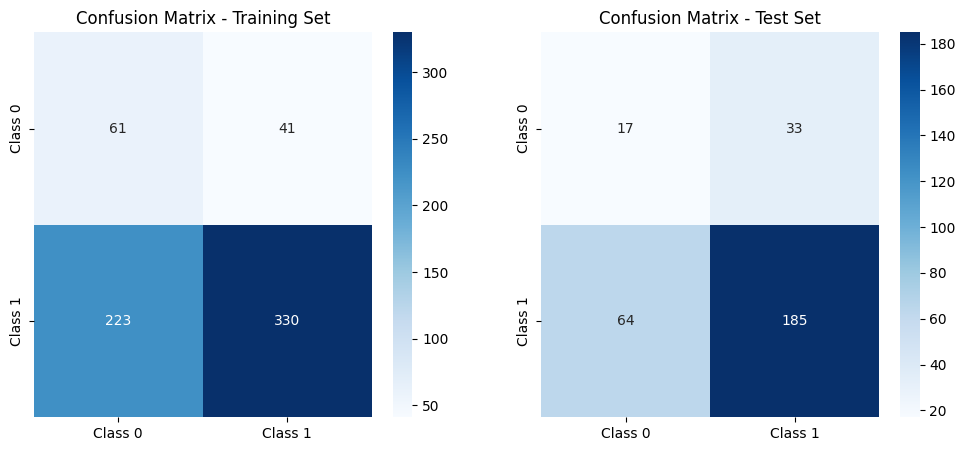

In [73]:
LR_model = make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', C=10))
LR_model.fit(X_train_smote, Y_train_smote)
LR_X_train_predicted = LR_model.predict(X_train_fn)
LR_X_test_predicted = LR_model.predict(X_test_fn)

conf_matrix(LR_X_train_predicted, LR_X_test_predicted)


#Support Vector Classifier

Training Accuracy:	 0.5847328244274809
Test  Accuracy:	 0.5953177257525084


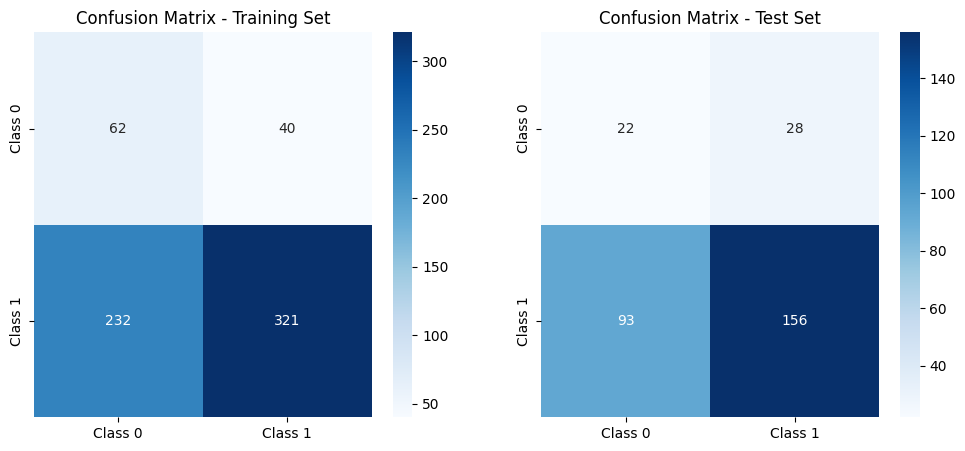

In [74]:
SVC_model = LinearSVC(C=0.5)
SVC_model.fit(X_train_smote, Y_train_smote)
SVC_X_train_predicted = SVC_model.predict(X_train_fn)
SVC_X_test_predicted = SVC_model.predict(X_test_fn)

conf_matrix(SVC_X_train_predicted,SVC_X_test_predicted)

#Decision Tree

Training Accuracy:	 0.9984732824427481
Test  Accuracy:	 0.6387959866220736


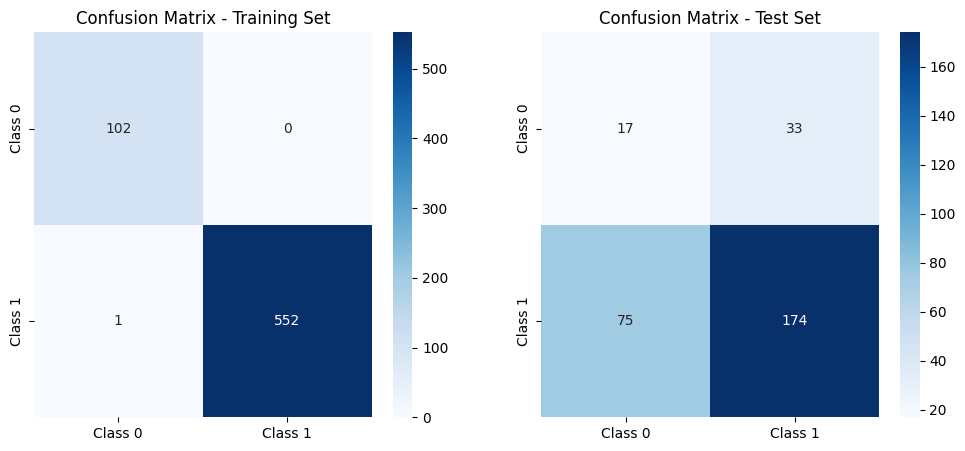

In [75]:
DT_model = DecisionTreeClassifier(max_depth=20, random_state=42)
DT_model.fit(X_train_smote, Y_train_smote)

DT_X_train_predicted =  DT_model.predict(X_train_fn)
DT_X_test_predicted = DT_model.predict(X_test_fn)

conf_matrix(DT_X_train_predicted,DT_X_test_predicted)

#Random Forest

Training Accuracy:	 0.9938931297709923
Test  Accuracy:	 0.7558528428093646


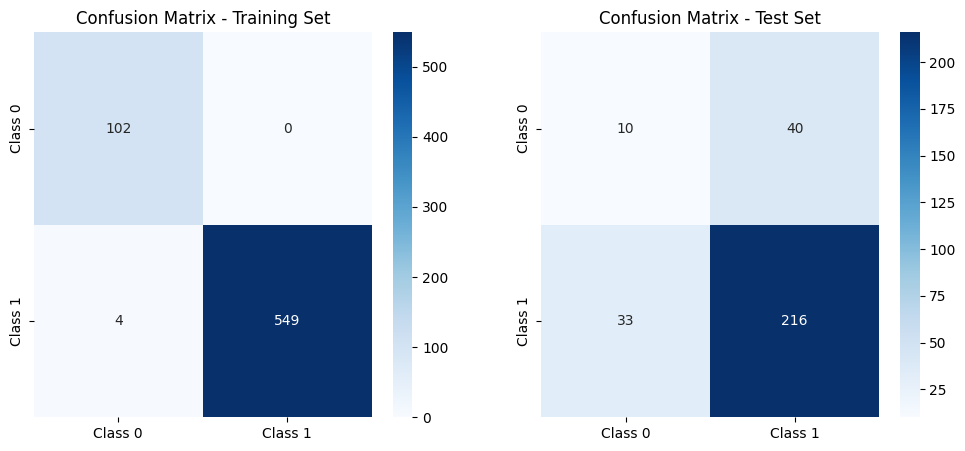

In [94]:
RF_model = RandomForestClassifier(n_estimators=26, max_depth=14, random_state=42)
RF_model.fit(X_train_smote, Y_train_smote)

RF_X_train_predicted = RF_model.predict(X_train_fn)
RF_X_test_predicted = RF_model.predict(X_test_fn)
conf_matrix(RF_X_train_predicted,RF_X_test_predicted)


#Gradiant Boost

Training Accuracy:	 0.8396946564885496
Test  Accuracy:	 0.822742474916388


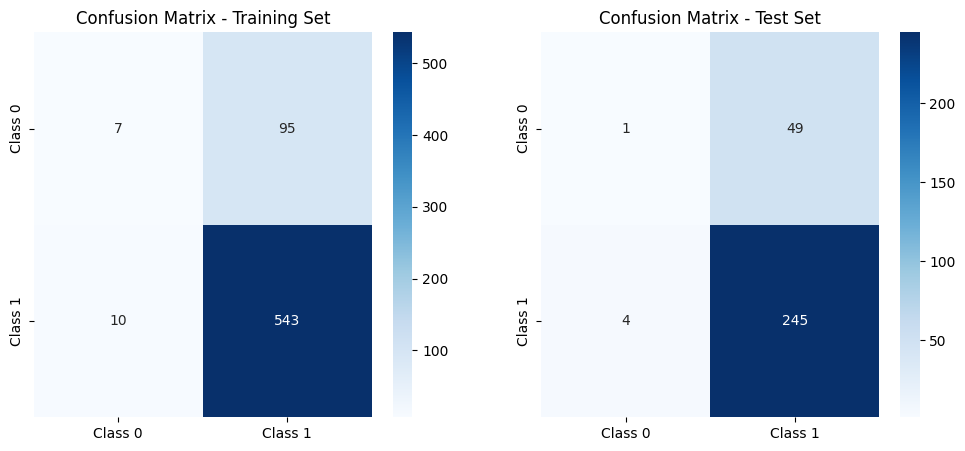

In [77]:

class_priors_original = np.bincount(Y_train) / len(Y_train)

NB_model = GaussianNB(priors=class_priors_original)
NB_model.fit(X_train_smote, Y_train_smote)

NB_X_train_predicted = NB_model.predict(X_train_fn)
NB_X_test_predicted = NB_model.predict(X_test_fn)
conf_matrix(NB_X_train_predicted,NB_X_test_predicted)


#XGBoost

Training Accuracy:	 0.9984732824427481
Test  Accuracy:	 0.725752508361204


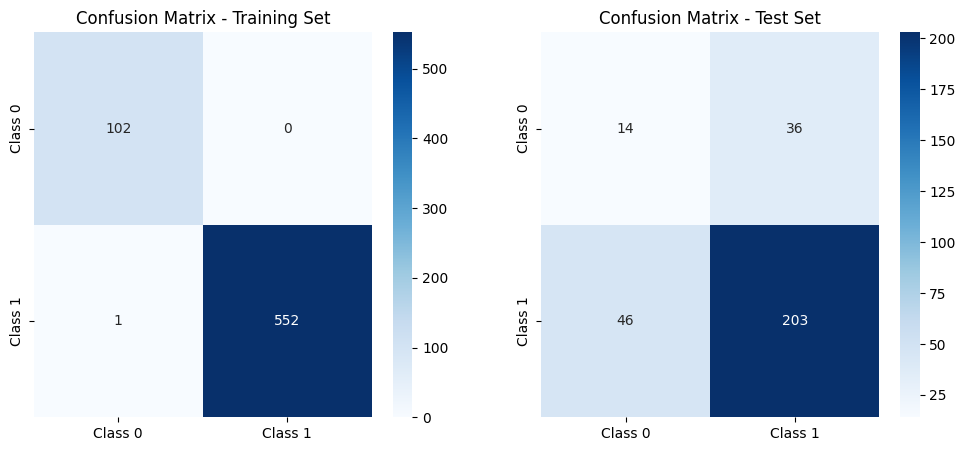

In [82]:

dtrain_smote = xgb.DMatrix(X_train_smote, label=Y_train_smote)
dtrain = xgb.DMatrix(X_train_fn, label=Y_train)
dtest = xgb.DMatrix(X_test_fn, label=Y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 20,
    'learning_rate': 0.2,
    'subsample': 1,
    'colsample_bytree': 1,
    'seed': 42
}

num_rounds = 13
xgb_model = xgb.train(params, dtrain_smote, num_rounds)

Y_pred_probs = xgb_model.predict(dtest)
xgb_X_test_predicted = [1 if prob > 0.5 else 0 for prob in Y_pred_probs]
X_pred_probs = xgb_model.predict(dtrain)
xgb_X_train_predicted = [1 if prob > 0.5 else 0 for prob in X_pred_probs]
conf_matrix(xgb_X_train_predicted,xgb_X_test_predicted)

#KNeighborsClassifier

Training Accuracy:	 1.0
Test  Accuracy:	 0.5852842809364549


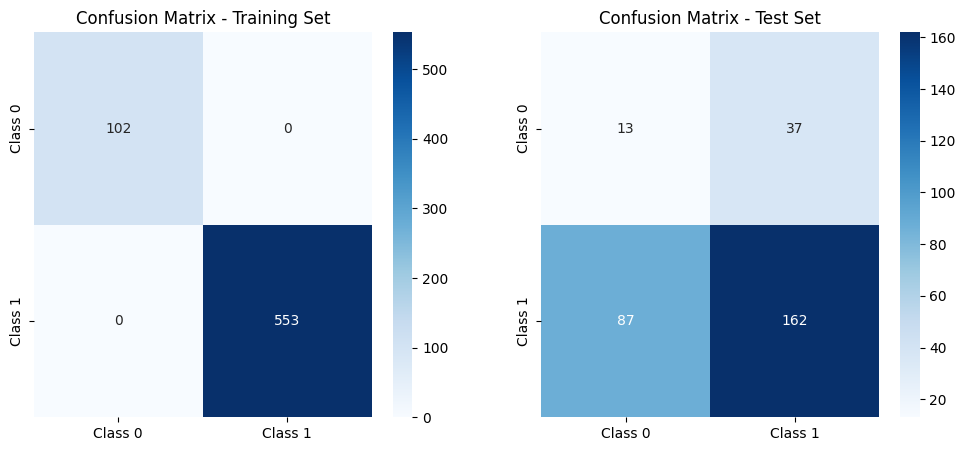

In [83]:

knn_model = KNeighborsClassifier(n_neighbors=1)

knn_model.fit(X_train_smote, Y_train_smote)

knn_X_train_predicted = knn_model.predict(X_train_fn)
knn_X_test_predicted = knn_model.predict(X_test_fn)

conf_matrix(knn_X_train_predicted,knn_X_test_predicted)

# 6 Methodology

***In my approach, I will split the data into training and testing sets using both Benchmark A standards and my custom feature-based method. Subsequently, I will train various models on each split, incorporating diverse algorithms and configurations. The assessment will focus on classification accuracy and a detailed examination of confusion matrices to understand how well the models perform across different classes. Ultimately, I will select the model with the highest accuracy and superior performance in class-specific predictions, as indicated by the confusion matrix. This tailored strategy ensures a nuanced comparison and the selection of the most effective model for my problem.***

# 7 Dataset



***The script classifies dishes in the MLENDYD_df DataFrame as 'rice', 'chips',  by examining keywords ('rice' or 'chips/fries/wedges') in the 'Ingredients' and 'Dish_name' columns.***

In [43]:
rice_rows = MLENDYD_df[MLENDYD_df['Dish_name'].str.contains('rice', case=False) | MLENDYD_df['Ingredients'].str.contains('rice', case=False)]

chips_rows = MLENDYD_df[(MLENDYD_df['Dish_name'].str.contains('chips|fries|wedges', case=False)) | (MLENDYD_df['Ingredients'].str.contains('chips|fries|wedges', case=False))]

rice_rows['Rice_Chips'] = 'rice'
chips_rows['Rice_Chips'] = 'chips'

<ipython-input-43-b01aaa455e5f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-43-b01aaa455e5f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


***The code merges the Rice and Chips dataset.***

In [44]:
merged_dataset = pd.concat([rice_rows, chips_rows], ignore_index=True)


***The code subsequently partitions the DataFrame into training and test sets, utilizing the 'Benchmark_A' column as the criterion for division.***

In [45]:
train_data = merged_dataset[merged_dataset['Benchmark_A'] == 'Train']
test_data = merged_dataset[merged_dataset['Benchmark_A'] == 'Test']

***Showing first five rows of train data***

In [46]:
display(train_data[:5])

,filename,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Rice_Chips
0,000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,rice
3,000021.jpg,non_vegetarian,asian,asian,biryani,home,"mutton,rice,onion,tomato,red_chilli_powder,sal...",healthy,4.0,strongly_like,5.0,Train,rice
4,000022.jpg,vegetarian,indian,indian,rice_beetroot_curry,home,"rice,beetroot,salt,spices",very_healthy,5.0,neutral,3.0,Train,rice
5,000026.jpg,non_vegetarian,pakistani,pakistani,chicken_biryani,home,"rice,chicken,biryani_masala,yogurt,oil,green_c...",healthy,4.0,strongly_like,5.0,Train,rice
6,000028.jpg,vegetarian,indian,indian,upma,home,"rice,onion,chilli,tomato,oil,pickle",healthy,4.0,neutral,3.0,Train,rice


***Showing first five rows of test data***

In [47]:
display(test_data[:5])

,filename,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Rice_Chips
1,000016.jpg,vegan,indian,indian,khichdi,home,"rice,spices,herbs",healthy,4.0,neutral,3.0,Test,rice
2,000020.jpg,vegetarian,indian,indian,lentil-based_vegetable_stew_with__rice,home,ingredients:\nfor_cooking_rice:\n1_cup_rice_(a...,healthy,4.0,like,4.0,Test,rice
8,000038.jpg,non_vegetarian,indian,indian,rice_with_chicken_curry,home,"boiled_rice,chicken,sunflower_oil,chilli_powde...",healthy,4.0,strongly_like,5.0,Test,rice
9,000039.jpg,vegetarian,south_indian,south_indian,khichidi,home,"rice,moong_lentils,ghee,cumin_seeds,ginger",very_healthy,5.0,like,4.0,Test,rice
10,000040.jpg,non_vegetarian,indian,indian,chicken_biryani,restaurant,"rice,chicken,potatos_and_spicy,",neutral,3.0,strongly_like,5.0,Test,rice


***Deleting the duplicates rows from train and test.***

In [48]:
train_data = train_data.drop_duplicates(subset='filename', keep='first')
test_data = test_data.drop_duplicates(subset='filename', keep='first')

**Showing the shape of train data after removing duplicates.**

In [49]:
train_data.shape

(655, 13)

**Showing the shape of train data after removing duplicates.**

In [50]:
test_data.shape

(299, 13)

**Shuffling the samples within the training and test datasets.**

In [51]:
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

***Showing first five rows of shuffled train data***

In [52]:
train_data[:5]

,filename,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Rice_Chips
0,001002.jpg,vegan,indian,indian,pulihora_with_ivy_gourd_curry,home,"rice,tamarind_pulp,mustard_seeds,split_chickpe...",healthy,4.0,strongly_dislike,1.0,Train,rice
1,002606.jpg,non_vegetarian,english,english,fish_and_chips,restaurant,"cod,chips",unhealthy,2.0,like,4.0,Train,chips
2,002483.jpg,non_vegetarian,american,american,chipotle,home,"rice,cilantro,lime,chicken,broccoli",very_healthy,5.0,strongly_like,5.0,Train,rice
3,000983.jpg,vegetarian,indian,indian,sorrel_leaves_biryani,home,"basmati_rice,bay_leaf,green_cardamom,cinnamon_...",very_healthy,5.0,strongly_like,5.0,Train,rice
4,000984.jpg,vegetarian,chinese,chinese,veggie_spring_roll,home,"shredded_vegetables_such_as_cabbage,carrots,on...",very_unhealthy,1.0,strongly_dislike,1.0,Train,rice


***Showing first five rows of shuffled test data***

In [53]:
test_data[:5]

,filename,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Rice_Chips
0,000814.jpg,non_vegetarian,south_african,south_african,nando's_butterfly_chicken_with_garlic_bread_an...,restaurant,"for_butterfly_chicken:\nwhole_chicken,nando's_...",healthy,4.0,strongly_like,5.0,Test,chips
1,000877.jpg,non_vegetarian,middle_eastern,middle_eastern,lamb_shawarma,capital_restaurant,"lamb,rice,butter,spices",unhealthy,2.0,dislike,2.0,Test,rice
2,000485.jpg,vegan,indian,indian,poha,home,"flat_rice,onion,mustard_seed,tomato,green_chil...",healthy,4.0,strongly_like,5.0,Test,rice
3,001624.jpg,vegetarian,north_indian,north_indian,buttered_rice_with_chickpea_gravy,home,"rice,ghee,salt,chickpeas,tomato,onion,channa_m...",very_healthy,5.0,dislike,2.0,Test,rice
4,002101.jpg,non_vegetarian,indian,indian,rice_with_roasted_chicken_slice,home,"boiled_rice,chicken,salt,garlic,ginger,garam_m...",healthy,4.0,like,4.0,Test,rice



**Having obtained all 3250 samples, we now need to segregate the paths corresponding only to 'rice' and 'chips' in X_train_paths and X_test_paths.**

In [54]:
TrainSet, TestSet,Map = yummy_load(datadir_main=baseDir,train_test_split='Benchmark_A')

Total 3250 found in /content/drive/MyDrive/Data/MLEnd_Full/yummy/MLEndYD_images/


In [55]:
X_train_paths = TrainSet['X_paths']
X_test_paths  = TestSet['X_paths']

In [56]:
import os

def filter_paths_by_filenames(paths, data, filename_column='filename'):
    filename_to_path = {os.path.basename(path): path for path in paths}
    filtered_filenames = [filename for filename in data[filename_column].values if filename in filename_to_path]
    filtered_paths = [filename_to_path[filename] for filename in filtered_filenames]
    return filtered_paths

X_train_paths = filter_paths_by_filenames(X_train_paths, train_data)
X_test_paths = filter_paths_by_filenames(X_test_paths, test_data)



***In this code, a LabelEncoder from scikit-learn is employed to convert categorical labels in the 'Rice_Chips' column of both the training ('train_data') and test ('test_data') datasets into numerical representations. The transformed labels are stored in 'Y_train' and 'Y_test', respectively.***

In [57]:
label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(train_data['Rice_Chips'])
Y_test = label_encoder.fit_transform(test_data['Rice_Chips'])


***This code is to visually showcase a few examples of rice and chips images from the dataset.***

Rice


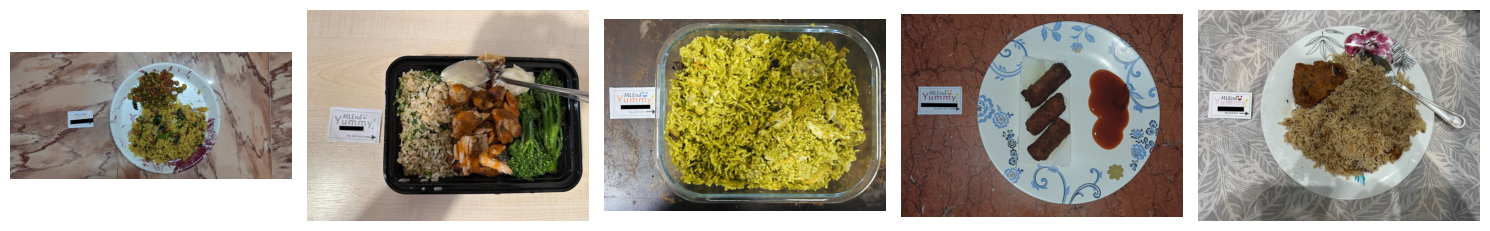

Chips


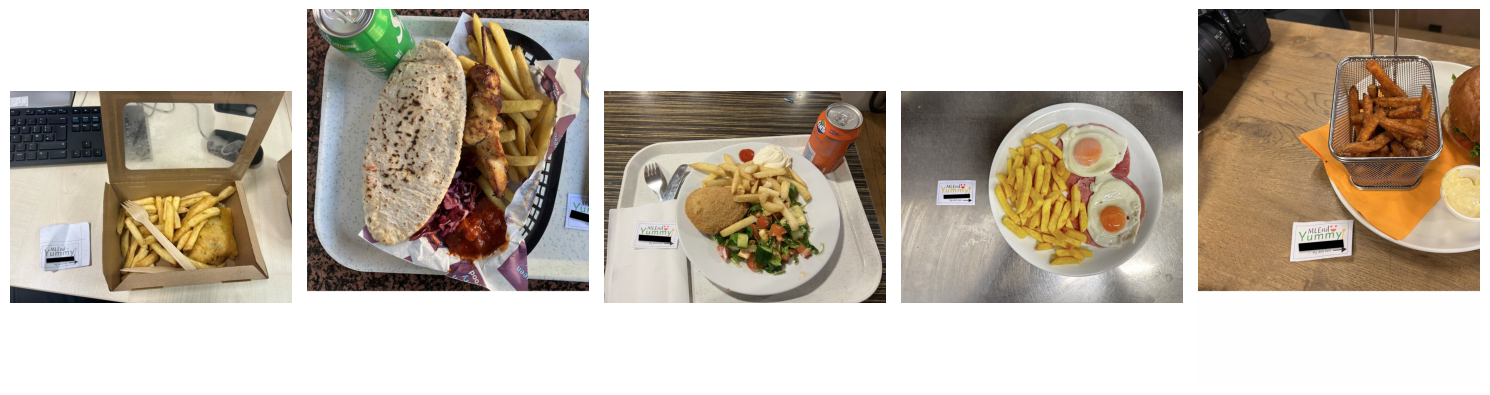

In [58]:
Chips_Img = np.array(X_train_paths)[Y_train==0]
Rice_Img = np.array(X_train_paths)[Y_train==1]

print('Rice')
plt.figure(figsize=(15,5))
for k,file in enumerate(Rice_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

print('Chips')
plt.figure(figsize=(15,5))
for k,file in enumerate(Chips_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

# 8 Results




***After evaluating various models, I found that the Random Forest Classifier RFC with hyperparameters (n_estimators=25, max_depth=15, and random_state=42) performs better than others. To assess the model's performance in more detail, I am presenting the confusion matrix to analyze the accuracy for each class in the Random Forest Classifier (RFC).***

Training Accuracy:	 0.9938931297709923
Test  Accuracy:	 0.7558528428093646


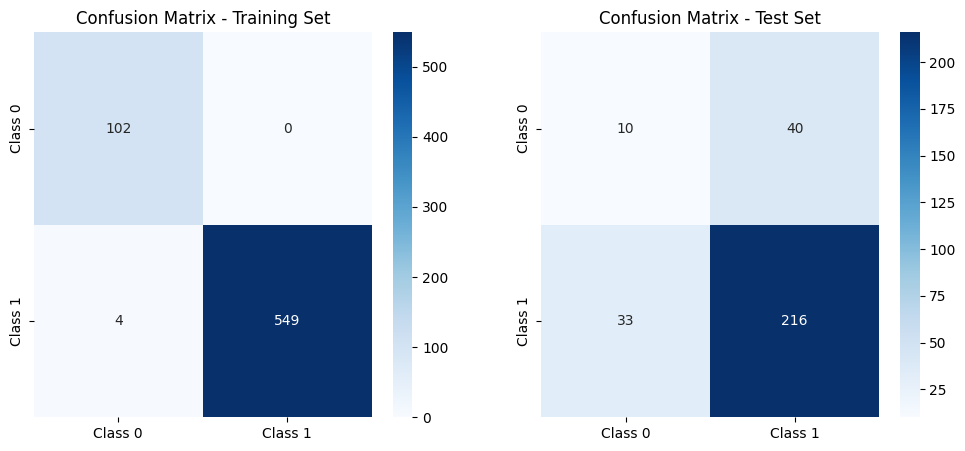

In [95]:
RF_model = RandomForestClassifier(n_estimators=26, max_depth=14, random_state=42)
RF_model.fit(X_train_smote, Y_train_smote)

RF_X_train_predicted = RF_model.predict(X_train_fn)
RF_X_test_predicted = RF_model.predict(X_test_fn)
conf_matrix(RF_X_train_predicted,RF_X_test_predicted)


***The code calculates and visualizes feature importances from a Random Forest model (RF_model). It creates a bar chart where each bar represents the importance of a feature, helping to identify the most influential features in the model.***

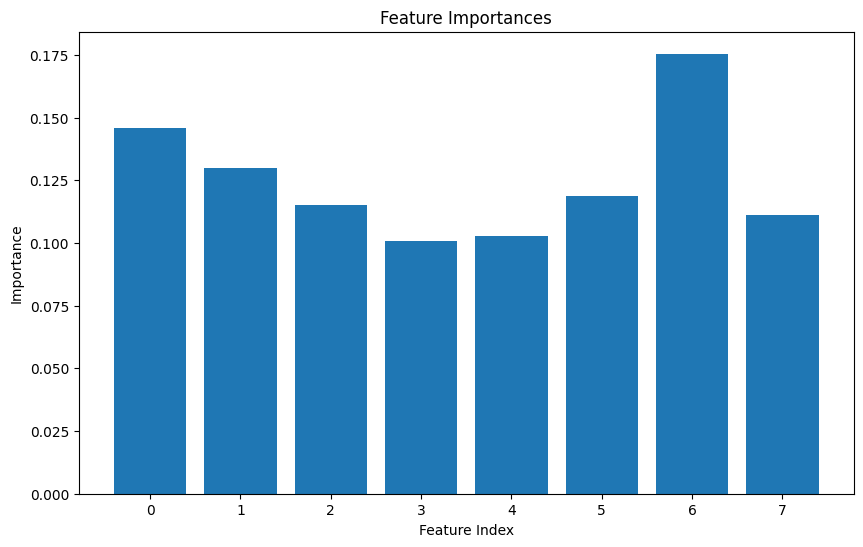

In [96]:

feature_importances = RF_model.feature_importances_


plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, align="center")
plt.xticks(range(len(feature_importances)), range(len(feature_importances)))
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

**This code snippet evaluates the performance of a RFC model using binary classification metrics. It calculates and prints the ROC-AUC score and Matthews correlation coefficient (MCC). Additionally, it generates a Receiver Operating Characteristic (ROC) curve, illustrating the trade-off between true positive rate and false positive rate, with the area under the curve (AUC) displayed.**

ROC-AUC: 0.6026907630522088
MCC: 0.07175305554934126


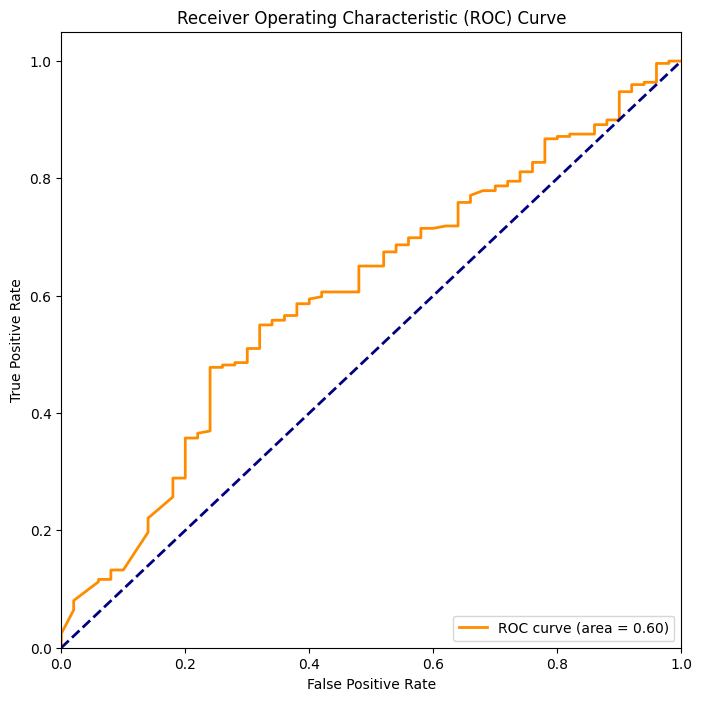

In [99]:
from sklearn.metrics import roc_auc_score, matthews_corrcoef, roc_curve, auc
import matplotlib.pyplot as plt

y_probs = RF_model.predict_proba(X_test_fn)[:, 1]

roc_auc = roc_auc_score(Y_test, y_probs)
print("ROC-AUC:", roc_auc)

mcc = matthews_corrcoef(Y_test, RF_X_test_predicted)
print("MCC:", mcc)

fpr, tpr, thresholds = roc_curve(Y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


***The provided code calculates a comprehensive classification report using scikit-learn's classification_report function. This report summarizes key classification metrics such as precision, recall, F1-score, and support for each class based on the true labels (Y_test) and the predicted labels (RF_X_test_predicted).***

In [105]:
classification_rep = classification_report(Y_test, RF_X_test_predicted)

print("Classification Report:")
print(classification_rep)


Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.20      0.22        50
           1       0.84      0.87      0.86       249

    accuracy                           0.76       299
   macro avg       0.54      0.53      0.54       299
weighted avg       0.74      0.76      0.75       299



# 9 Conclusions

***After an exhaustive evaluation of multiple models, the Random Forest Classifier (RFC) has emerged as the top-performing model, showcasing superior results with hyperparameters set to n_estimators=25, max_depth=15, and random_state=42. To delve deeper into the model's efficacy, a detailed examination via the confusion matrix has been presented. .***



#Improvement

**While the model demonstrates strong performance for Class 1, there is a clear need for improvement in handling instances of Class 0. The overall model accuracy of 76% leaves room for enhancement, and future iterations should focus on refining the model through hyperparameter tuning, feature engineering, and addressing class imbalance to achieve a more balanced and accurate predictive outcome.**

***Given the imbalance in class distribution, further attention could be directed toward improving the model's performance on Class 0, potentially through data augmentation or targeted feature engineering***


